Install TensorFlow and TensorFlow Model Garden

In [1]:
import tensorflow as tf


2022-11-03 10:04:46.398406: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-03 10:04:51.445129: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-11-03 10:04:53.988618: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-03 10:05:33.676790: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: li

In [2]:
!git clone --depth 1 -b v2.3.0 https://github.com/tensorflow/models.git

fatal: destination path 'models' already exists and is not an empty directory.


1: Download and Import the Quora Insincere Questions Dataset

In [3]:
import random
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

import tensorflow_hub as hub
import sys
sys.path.append('models')
from official.nlp.data import classifier_data_lib
from official.nlp.bert import tokenization
from official.nlp import optimization

/home/hpc-lavasa/Desktop/Drive/Subham/venv-cpu/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
print("TF Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print(tf.config.experimental.list_physical_devices())
print("GPU is", "available" if tf.config.experimental.list_physical_devices(
    "gpu") else "NOT AVAILABLE")


TF Version:  2.10.0
Eager mode:  True
Hub version:  0.12.0
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU is NOT AVAILABLE


2022-11-03 10:06:13.143212: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-03 10:06:13.249222: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-03 10:06:13.249374: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [5]:
df = pd.read_csv('https://archive.org/download/fine-tune-bert-tensorflow-train.csv/train.csv.zip',
                 compression='zip', low_memory=False)
df


,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0
...,...,...,...
1306117,ffffcc4e2331aaf1e41e,What other technical skills do you need as a c...,0
1306118,ffffd431801e5a2f4861,Does MS in ECE have good job prospects in USA ...,0
1306119,ffffd48fb36b63db010c,Is foam insulation toxic?,0
1306120,ffffec519fa37cf60c78,How can one start a research project based on ...,0


In [6]:
df.target.value_counts()


0    1225312
1      80810
Name: target, dtype: int64

2: Create tf.data.Datasets for Training and Evaluation

In [7]:
train, validation = train_test_split(
    df, train_size=0.60, random_state=42, stratify=df.target.values)
validation, test = train_test_split(
    validation, random_state=42, test_size=0.5, stratify=validation.target.values)
print("Train Shape\tValid Shape\tTest Shape")
train.shape, validation.shape, test.shape


Train Shape	Valid Shape	Test Shape


((783673, 3), (261224, 3), (261225, 3))

In [8]:
with tf.device('/cpu:0'):
    train_data = tf.data.Dataset.from_tensor_slices(
        (train['question_text'].values, train['target'].values))
    valid_data = tf.data.Dataset.from_tensor_slices(
        (validation['question_text'].values, validation['target'].values))
    test_data = tf.data.Dataset.from_tensor_slices(
        (test['question_text'].values, test['target'].values))

    for text, label in train_data.take(1):
        print(test)
        print(label)


2022-11-03 10:07:12.327801: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-03 10:07:12.335307: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-03 10:07:12.335447: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-03 10:07:12.335495: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA

                          qid  \
22004    0452e4e5b5c34944bc36   
1013706  c6a65b5d62175723a176   
659002   8114ca3a08a56ade83d9   
1299258  fea6446c17da271b7426   
850519   a6a69b2770aa2dcf3073   
...                       ...   
503308   628c8ecf3b45b64c0a65   
1065936  d0e1a71eee5f806706f2   
319173   3e8d066aed1996792729   
286674   3823c5055028979fa0ab   
131093   19a5635a21c045709a26   

                                             question_text  target  
22004    What is the most witty response to something y...       0  
1013706  What are some products everyone really wants t...       0  
659002   What prevents both pilots from hijacking an ai...       0  
1299258  Does the behavior of matter change under envir...       0  
850519   What is that white and clear vaginal discharge...       0  
...                                                    ...     ...  
503308   Do you feel job posted on Indian job sites lik...       0  
1065936  What are the difference of "believing anyt

3: Download a Pre-trained BERT Model from TensorFlow Hub

In [9]:
"""
Each line of the dataset is composed of the review text and its label
- Data preprocessing consists of transforming text to BERT input features:
input_word_ids, input_mask, segment_ids
- In the process, tokenizing the text is done with the provided BERT model tokenizer
"""
labels_list = [0, 1]
max_seq_len = 150
batch = 64

#: https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2
bert_layer = hub.KerasLayer(
    'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2', trainable=False)
vocab = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab, do_lower_case)


In [10]:
tokenizer.wordpiece_tokenizer.tokenize("hi, how, are you")


['hi', '##,', 'how', '##,', 'are', 'you']

In [11]:
tokenizer.wordpiece_tokenizer.tokenize("hi, How, are you")


['hi', '##,', '[UNK]', 'are', 'you']

In [12]:
tokenizer.convert_tokens_to_ids(
    tokenizer.wordpiece_tokenizer.tokenize("hi, how, are you"))


[7632, 29623, 2129, 29623, 2024, 2017]

4: Tokenize and Preprocess Text for BERT

In [13]:
# This provides a function to convert row to input features and label

def to_feature(text, label, label_list=labels_list, max_seq_length=max_seq_len, tokenizer=tokenizer):

    example = classifier_data_lib.InputExample(guid=None,
                                               text_a=text.numpy(),
                                               text_b=None,
                                               label=label.numpy()
                                               )
    feature = classifier_data_lib.convert_single_example(
        0, example, label_list, max_seq_length, tokenizer)

    return (feature.input_ids, feature.input_mask, feature.segment_ids, feature.label_id)


5: Wrap a Python Function into a TensorFlow op for Eager Execution

In [14]:
def to_feature_map(text, label):
    input_ids, input_mask, segment_ids, label_id = tf.py_function(to_feature, inp=[text, label],
                                                                  Tout=[
                                                                      tf.int32, tf.int32, tf.int32, tf.int32]
                                                                  )
    input_ids.set_shape([max_seq_len])
    input_mask.set_shape([max_seq_len])
    segment_ids.set_shape([max_seq_len])
    label_id.set_shape([])

    x = {
        'input_word_ids': input_ids,
        'input_mask': input_mask,
        'input_type_ids': segment_ids
    }
    return (x, label_id)


6: Create a TensorFlow Input Pipeline with tf.data

In [15]:
with tf.device('/cpu:0'):
    # train
    train_data = (train_data.map(to_feature_map,
                                 num_parallel_calls=tf.data.experimental.AUTOTUNE
                                 )
                  .shuffle(1000)
                  .batch(batch, drop_remainder=True)
                  .prefetch(tf.data.experimental.AUTOTUNE)
                  )

    # valid
    valid_data = (valid_data.map(to_feature_map,
                                 num_parallel_calls=tf.data.experimental.AUTOTUNE
                                 )
                  .batch(batch, drop_remainder=True)
                  .prefetch(tf.data.experimental.AUTOTUNE)
                  )

    # test
    test_data = (test_data.map(to_feature_map,
                               num_parallel_calls=tf.data.experimental.AUTOTUNE
                               )
                 .batch(batch, drop_remainder=True)
                 .prefetch(tf.data.experimental.AUTOTUNE)
                 )


In [16]:
# train data spec
train_data.element_spec


({'input_word_ids': TensorSpec(shape=(64, 150), dtype=tf.int32, name=None),
  'input_mask': TensorSpec(shape=(64, 150), dtype=tf.int32, name=None),
  'input_type_ids': TensorSpec(shape=(64, 150), dtype=tf.int32, name=None)},
 TensorSpec(shape=(64,), dtype=tf.int32, name=None))

In [17]:
# valid data spec
valid_data.element_spec


({'input_word_ids': TensorSpec(shape=(64, 150), dtype=tf.int32, name=None),
  'input_mask': TensorSpec(shape=(64, 150), dtype=tf.int32, name=None),
  'input_type_ids': TensorSpec(shape=(64, 150), dtype=tf.int32, name=None)},
 TensorSpec(shape=(64,), dtype=tf.int32, name=None))

7: Add a Classification Head to the BERT Layer

In [18]:
# Building the model
def create_model():
    input_word_ids = tf.keras.layers.Input(shape=(max_seq_len,), dtype=tf.int32,
                                           name="input_word_ids")
    input_mask = tf.keras.layers.Input(shape=(max_seq_len,), dtype=tf.int32,
                                       name="input_mask")
    segment_ids = tf.keras.layers.Input(shape=(max_seq_len,), dtype=tf.int32,
                                        name="segment_ids")
    pooled_output, sequence_output = bert_layer(
        [input_word_ids, input_mask, segment_ids])

    drop = tf.keras.layers.Dropout(0.3)(pooled_output)
    dense_1 = tf.keras.layers.Dense(512, activation='relu')(drop)
    dense_2 = tf.keras.layers.Dense(1024, activation='relu')(dense_1)
    dense_3 = tf.keras.layers.Dense(1024, activation='relu')(dense_2)
    drop = tf.keras.layers.Dropout(0.4)(dense_3)

    output = tf.keras.layers.Dense(
        1, activation='sigmoid', name='output')(drop)

    model = tf.keras.Model(
        {
            'input_word_ids': input_word_ids,
            'input_mask': input_mask,
            'input_type_ids': segment_ids
        },
        output
    )
    return model


8: Fine-Tune BERT for Text Classification

In [19]:
model = create_model()
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=2e-4),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=['binary_accuracy']
)
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_word_ids (InputLayer)    [(None, 150)]        0           []                               
                                                                                                  
 input_mask (InputLayer)        [(None, 150)]        0           []                               
                                                                                                  
 segment_ids (InputLayer)       [(None, 150)]        0           []                               
                                                                                                  
 keras_layer (KerasLayer)       [(None, 768),        109482241   ['input_word_ids[0][0]',         
                                 (None, 150, 768)]                'input_mask[0][0]',         

In [20]:
tf.keras.utils.plot_model(model, show_shapes=True, dpi=80)


You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [21]:
# Train model
h = model.fit(train_data, validation_data=valid_data,
              epochs=5
              )


Epoch 1/5


2022-11-03 10:08:49.029726: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


12244/12244 [==============================] - 2084s 170ms/step - loss: 0.1761 - binary_accuracy: 0.9397 - val_loss: 0.1506 - val_binary_accuracy: 0.9440
Epoch 2/5
12244/12244 [==============================] - 2082s 170ms/step - loss: 0.1678 - binary_accuracy: 0.9404 - val_loss: 0.1502 - val_binary_accuracy: 0.9428
Epoch 3/5
12244/12244 [==============================] - 2079s 170ms/step - loss: 0.1655 - binary_accuracy: 0.9409 - val_loss: 0.1471 - val_binary_accuracy: 0.9421
Epoch 4/5
12244/12244 [==============================] - 2080s 170ms/step - loss: 0.1637 - binary_accuracy: 0.9412 - val_loss: 0.1467 - val_binary_accuracy: 0.9435
Epoch 5/5
12244/12244 [==============================] - 2082s 170ms/step - loss: 0.1630 - binary_accuracy: 0.9413 - val_loss: 0.1459 - val_binary_accuracy: 0.9443


9: Evaluate the BERT Text Classification Model

In [22]:
import matplotlib.pyplot as plt


def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])
    plt.show()


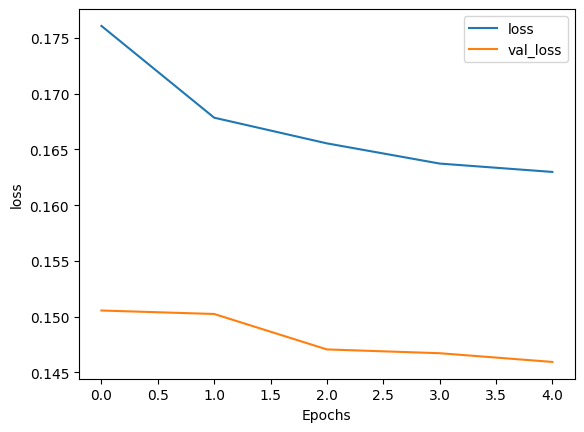

In [23]:
plot_graphs(h, 'loss')


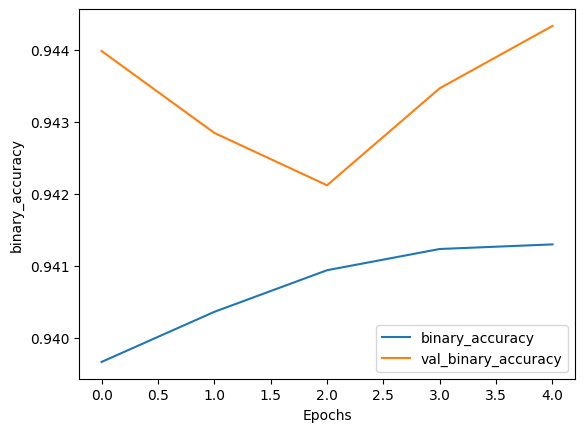

In [24]:

plot_graphs(h, 'binary_accuracy')


In [25]:
model.evaluate(test_data)


4081/4081 [==============================] - 520s 127ms/step - loss: 0.1459 - binary_accuracy: 0.9447


[0.14588764309883118, 0.9447247982025146]

In [26]:
sample_example = ['may i have your number??']
ques = tf.data.Dataset.from_tensor_slices(
    (sample_example, [0]*len(sample_example)))
ques = (ques.map(to_feature_map)).batch(1)
pred = model.predict(ques)[0][0]
t = 0.5
['Insincere' if pred >= t else 'Sincere']


1/1 [==============================] - 0s 295ms/step


['Sincere']

In [27]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  1
